In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/diff_lambdas_bigger_redshifts2.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta
0,622.435157,273.663456,839.999976,0.00001,0.000000,1107.847716,1107.841588,5.000000e-07,0.00001
1,623.866125,275.052142,842.753995,0.00001,0.020204,1111.355899,1111.379081,5.000000e-07,0.00001
2,625.309897,276.456929,845.411754,0.00001,0.040408,1114.979916,1114.959961,5.000000e-07,0.00001
3,626.766685,277.881186,848.271396,0.00001,0.060612,1118.535855,1118.585217,5.000000e-07,0.00001
4,628.236710,279.321571,851.043919,0.00001,0.080816,1122.202831,1122.255869,5.000000e-07,0.00001


In [3]:
df.values[0]

array([  6.22435157e+02,   2.73663456e+02,   8.39999976e+02,
         1.00000572e-05,   0.00000000e+00,   1.10784772e+03,
         1.10784159e+03,   5.00000000e-07,   1.00000000e-05])

In [4]:
length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale
# print(M)
print(4*M/201.990641/9.99960083e-06)
Lambda = 3*0.726531*H_0**2
print(Lambda*(201.990641*9.99960083e-06)**3/6/M)
print(15*np.pi/4*M**2/(201.990641*9.99960083e-06)**2)

9.459052628595836e-05
3.411141700982049e-09
6.588043246691985e-09


In [5]:
# # patch
# length_scale = 3.086e22
# H_0 = 7.56e-27 * length_scale
# M = 1474e12 / length_scale

# z_lens1 = np.linspace(0.05, 0.2, 100)
# z_lens2 = []
# for z in z_lens1:
#     z_lens2.extend([z]*50)

# # print(len(z_lens2), len(df.index))
# df['z_lens'] = z_lens2[:len(df.index)]

# def get_distances(z, Omega_Lambda=0):
#     Omega_m = 1 - Omega_Lambda
#     def integrand(z):
#         return 1/np.sqrt(Omega_m*(1+z)**3 + Omega_Lambda)
#     integral, error = spi.quad(integrand, 0, z)
#     comoving = integral/H_0
#     dang = comoving/(1+z)
#     return comoving, dang

# dang_lens = []
# for index, row in df.iterrows():
#     com, dang = get_distances(row.z_lens, row.om_lambdas)
#     dang_lens.append(dang)

# df['DL'] = dang_lens

In [6]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale

def calc_theta(D_LS, D_L, D_S):
    return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    
    rho = (1-row.om_lambdas)*3*H_0**2/(8*np.pi)
    r_h = (3*M/(4*np.pi*rho))**(1./3)
    

#     row.DLS*Lambda*row.DL**3/6/M,
#     coeff = [row.DLS*Lambda*row.DL**3/6/M, 0, row.DS, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -305/12*M**3*row.DLS/row.DL**3]
    coeff = [row.DS + Lambda*row.DL*row.DLS*r_h/3, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -305/12*M**3*row.DLS/row.DL**3]
#     if index < 50:
#         print(row.om_lambdas, 15*np.pi/4*M**2/(row.DL*row.theta)**2, Lambda*(row.DL*row.theta)*r_h/3)
    roots = np.roots(coeff)
    roots = roots[roots>0 & np.isreal(roots)]
    th = np.real(roots)
    rindler = th[np.argmin(np.abs(row.theta - th))]

    # coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    coeff2 = [row.DS, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -401/12*M**3*row.DLS/row.DL**3]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0 & np.isreal(roots2)]
    th2 = np.real(roots2)
    second_order = th2[np.argmin(np.abs(row.theta - th2))]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)
    
#     if 990 < index < 1000:
#         calculated_ds = row.DLS*(4*M/(row.DL*rindler) + 15*np.pi*M**2/4/(row.DL*rindler)**2 + 305/12*M**3/(row.DL*rindler)**3 - Lambda*(row.DL*rindler)**3/6/M)/rindler
#         print(row.om_lambdas)
#         print(row.DS, calculated_ds)
#         print((rindler - row.theta)/row.theta)
#         print("==")

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


# ## removed percentage!!

df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta

# df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta*100
# df['percentage_diff'] = (df.rs - df.rs_initial)/df.rs_initial*100

In [7]:
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,622.435157,273.663456,839.999976,0.00001,0.000000,1107.847716,1107.841588,5.000000e-07,0.00001,0.00001,0.00001,0.000017,0.000017
1,623.866125,275.052142,842.753995,0.00001,0.020204,1111.355899,1111.379081,5.000000e-07,0.00001,0.00001,0.00001,-0.000010,-0.000010
2,625.309897,276.456929,845.411754,0.00001,0.040408,1114.979916,1114.959961,5.000000e-07,0.00001,0.00001,0.00001,0.000030,0.000029
3,626.766685,277.881186,848.271396,0.00001,0.060612,1118.535855,1118.585217,5.000000e-07,0.00001,0.00001,0.00001,-0.000034,-0.000034
4,628.236710,279.321571,851.043919,0.00001,0.080816,1122.202831,1122.255869,5.000000e-07,0.00001,0.00001,0.00001,-0.000037,-0.000038


In [8]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats['rindler_preds mean std'] = stats['rindler_preds std']/np.sqrt(stats['rindler_preds count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std,rindler_preds mean std
om_lambdas,,,,,,,,
0.000000,1.878952e-05,0.000254,34,1.878949e-05,0.000254,34,0.000044,0.000044
0.020204,-4.971420e-05,0.000254,34,-5.006281e-05,0.000254,34,0.000044,0.000044
0.040408,-4.772618e-05,0.000240,34,-4.843262e-05,0.000240,34,0.000041,0.000041
0.060612,-3.151077e-06,0.000169,34,-4.225232e-06,0.000169,34,0.000029,0.000029
0.080816,8.479182e-06,0.000165,34,7.027184e-06,0.000165,34,0.000028,0.000028
0.101020,1.972041e-05,0.000268,34,1.787986e-05,0.000268,34,0.000046,0.000046
0.121224,-2.857718e-05,0.000223,34,-3.081703e-05,0.000223,34,0.000038,0.000038
0.141429,-4.875609e-05,0.000247,34,-5.140708e-05,0.000247,34,0.000042,0.000042
0.161633,-5.547460e-05,0.000230,34,-5.854937e-05,0.000230,34,0.000039,0.000039


In [9]:
stats.values[0]

array([  1.87895204e-05,   2.54290839e-04,   3.40000000e+01,
         1.87894941e-05,   2.54290838e-04,   3.40000000e+01,
         4.36105191e-05,   4.36105189e-05])

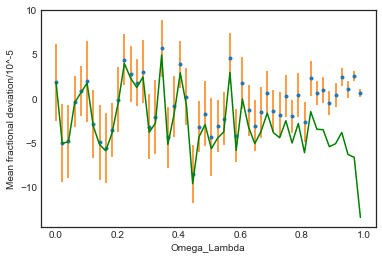

In [13]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean fractional deviation/10^-5')
plt.plot(stats.index, stats['rindler_preds mean']/scale, 'g-')
plt.savefig('fractional deviation.png')
# plt.errorbar(stats.index, stats['rindler_preds mean']/scale, yerr=stats['rindler_preds mean std']/scale, linestyle='none')

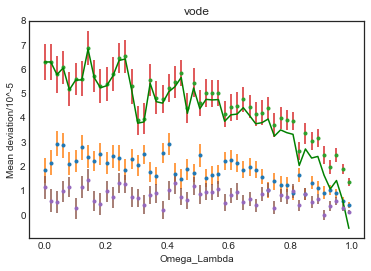

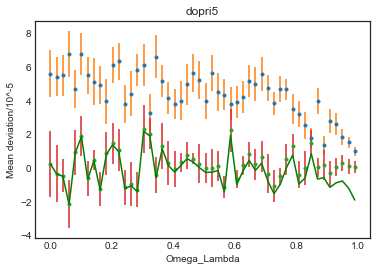

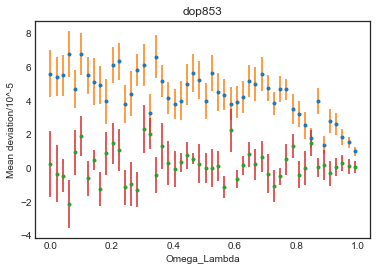

In [11]:
from util import plot_diff_lambdas
plt.figure()
plt.title("vode")
plot_diff_lambdas('data/diff_lambdas_small2.csv', recalculate_distances=True)
plot_diff_lambdas('data/diff_lambdas_step.csv', plot_rindler=True)
plot_diff_lambdas('data/diff_lambdas_step2.csv')
plt.figure()
plt.title("dopri5")
plot_diff_lambdas('data/dopri5_diff_lambdas.csv')
plot_diff_lambdas('data/dopri5_diff_lambdas2.csv', plot_rindler=True)
plt.figure()
plt.title("dop853")
plot_diff_lambdas('data/dop853_diff_lambdas.csv')
plot_diff_lambdas('data/dop853_diff_lambdas2.csv')